In [197]:
import cvxpy as cp
import numpy as np
import itertools

from pydantic import BaseModel

import matplotlib.pyplot as plt
from sklearn import decomposition

## Example: reduce a circle in 3D to 2D

We added a third coordinate that makes circle look wavy in 3d

In [244]:
t = np.linspace(0, 2 * np.pi)

circle_3d = np.array([
    np.real(np.exp(t * 1j)),
    np.imag(np.exp(t * 1j)),
    np.sin(6*t)
]).T

X = circle_3d 

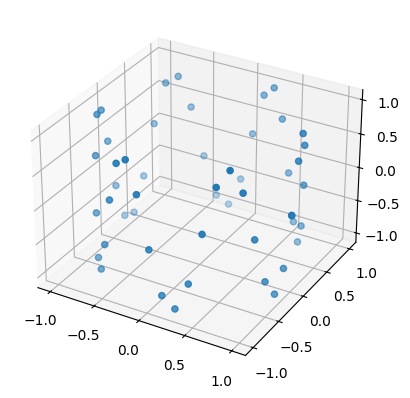

In [245]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
ax.scatter(X[:,0], X[:,1], X[:,2], marker="o")


In [270]:
# wtf, why doesn't cvxpy work when using vectorized slices :(

#K_norms = get_selected_norms(K, indices_i, indices_j)
#G_norms = get_selected_norms(G, indices_i, indices_j)

def get_selected_norms(kernel, indices_i, indices_j):
    return kernel[indices_i, indices_i] + kernel[indices_j, indices_j] - 2 * kernel[indices_i, indices_j]

In [273]:
decomposition.KernelPCA

sklearn.decomposition._kernel_pca.KernelPCA

## MVU method

MVU is a dimensionality reduction algorithm that works like KPCA but the kernel is learned and it can be made local.

Locality means that it depends on a parameter of selected neighbors for which the kernel is optimized.

### MVU Algorithm

#### Inputs

$X = (x_i)_{i \leq N}$ - dataset.

$G_{ij} = X X^T$ - the dataset's kernel.

$E$ - a set of pairs $(i,j)$. These are the pairs of indices where $\|x_i - x_j\|$ is small (they are nearest neighbors in some sense)

#### Optimization

$K$ is a kernel $N \times N$ matrix

maximize $(tr(K))$

Subjected to constraints

$K_{ii} + K_{jj} - 2 K_{ij} = G_{ii} + G_{jj} - 2 G_{ij}$ where $(i,j) \in E$ 

$\sum_{i,j} K_{ij} = 0$

$K \succcurlyeq 0$

$K^T = K$

#### Explanation

The last two are just the conditions for a kernel. The zero sum condition means that kernel is centered.

Since $K$ is a kernel, there are some $Z = (z_i)_{i \leq N}$

such that $\| z_i - z_j \|^2 = K_{ii} + K_{jj} - 2 K_{ij}$

Which means that the first condition is equivalent to $\| z_i - z_j \| = \| x_i - x_j \|$ for $(i,j) \in E$.

**When $E$ is a set of indices of nearest neighbors this means that MVU is local.** Such local methods are commonly called manifold learning.

In [278]:
N = 50
dim = 2

# indices of nearest neighbors

indices_i = np.arange(0, 50, 2)
indices_j = np.arange(0, 50, 2) + 1



class MaximumVarianceUnfolder(BaseModel):
    kpca: decomposition.KernelPCA

    @classmethod
    def create(cls, n_components=2):
        kpca = decomposition.KernelPCA(n_components=n_components, kernel="precomputed")
        return cls(kpca=kpca)
        
    def fit_transform(self, X, neighbor_indices, verbose=False):
        neighbor_indices = self._get_neighbor_indices(X, neighbor_indices)
        _, K = self._solve_optimization_problem(X, neighbor_indices, verbose=verbose)
        return self.kpca.fit_transform(K)
    
    def _get_neighbor_indices(self, X, neighbor_indices):
        if neighbor_indices is not None:
            return neighbor_indices
        else:
            raise NotImplementedError("pass neighbor indices")
    
    def _solve_optimization_problem(self, X, neighbor_indices, verbose=False):
        N = X.shape[0]
        indices_i, indices_j = neighbor_indices
        
        K = cp.Variable((N, N), PSD=True)
        G = cp.Constant(X @ X.T)
        
        objective = cp.Maximize(cp.trace(K))
        
        norm_constraints = [K[i,i] + K[j,j] - 2 * K[i,j] == G[i,i] + G[j,j] - 2 * G[i,j]
            for (i, j) in itertools.product(indices_i, indices_j)]
        
        constraints = norm_constraints + [
            cp.transpose(K) == K,
            cp.sum(K) == 0
        ]
        
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=verbose)
        return problem, K.value

    class Config:
        arbitrary_types_allowed = True

In [279]:
mv_unfolder = MaximumVarianceUnfolder.create()

In [280]:
mv_unfolder.fit_transform(X, (indices_i, indices_j), verbose=True)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Mar 17 02:38:47 PM: Your problem has 2500 variables, 627 constraints, and 0 parameters.
(CVXPY) Mar 17 02:38:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 17 02:38:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 17 02:38:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 17 02:38:47 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 17 02:38:47 PM: Compiling problem (target solver=SCS).
(

array([[-9.80000049e-01,  2.21900941e-08],
       [-9.71790045e-01, -1.25930549e-01],
       [-9.47294892e-01, -2.50857563e-01],
       [-9.06916788e-01, -3.73194673e-01],
       [-8.51318735e-01, -4.90536400e-01],
       [-7.81413656e-01, -5.99921603e-01],
       [-6.98349353e-01, -6.98464353e-01],
       [-6.03489835e-01, -7.84015580e-01],
       [-4.98392570e-01, -8.55497162e-01],
       [-3.84783367e-01, -9.12735883e-01],
       [-2.64527582e-01, -9.55902522e-01],
       [-1.39599912e-01, -9.84883549e-01],
       [-1.20515567e-02, -9.98947570e-01],
       [ 1.16023007e-01, -9.96901339e-01],
       [ 2.42520968e-01, -9.77651427e-01],
       [ 3.65365041e-01, -9.40856979e-01],
       [ 4.82538324e-01, -8.87305450e-01],
       [ 5.92116663e-01, -8.18796295e-01],
       [ 6.92300920e-01, -7.37593302e-01],
       [ 7.81445973e-01, -6.45745639e-01],
       [ 8.58088148e-01, -5.44651298e-01],
       [ 9.20968895e-01, -4.35095804e-01],
       [ 9.69055784e-01, -3.17732326e-01],
       [ 1.

In [249]:
Z = decomposition.KernelPCA(n_components = 2, kernel="precomputed").fit_transform(K)

In [250]:
Y = decomposition.PCA(n_components=2).fit_transform(X)

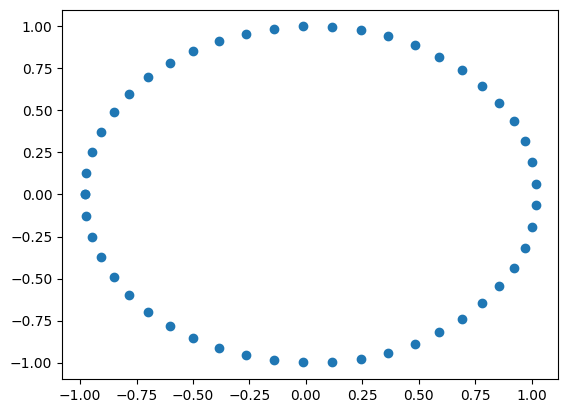

In [251]:
plt.scatter(Z[:,0], Z[:,1])

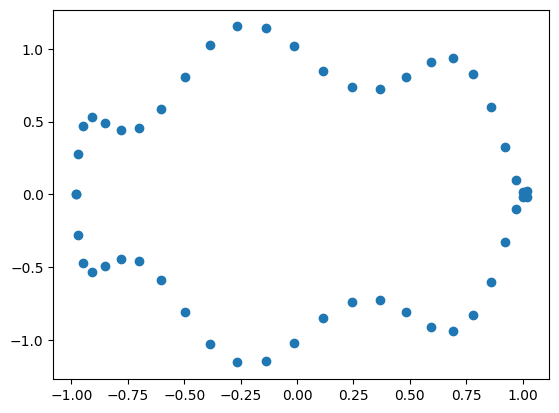

In [253]:
plt.scatter(Y[:,0], Y[:,1])

Warning: note that Y and Z are projected to 2D space which is not necessarily the $x_3=0$ plane. 

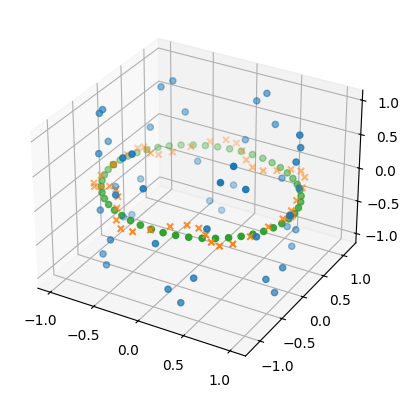

In [260]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
ax.scatter(X[:,0], X[:,1], X[:,2], marker="o")
ax.scatter(Y[:,0], Y[:,1], marker="x")
ax.scatter(Z[:,0], Z[:,1], marker="o")

plt.show()